In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_curve, auc
from scipy.special import expit
from scipy import interpolate
from scipy import integrate
from collections import Counter
from matplotlib.colors import ListedColormap
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))

In [3]:
import warnings
warnings.filterwarnings('default')

In [3]:
def interpolate_roc_fun(fpr, tpr, n_grid):
    """https://github.com/VaibhavKaushik3220/abroca/blob/main/abroca/compute_abroca.py"""
    roc_approx = interpolate.interp1d(x=fpr, y=tpr)
    x_new = np.linspace(0, 1, num=n_grid)
    y_new = roc_approx(x_new)
    return x_new, y_new

In [4]:
def compute_abroca(fpr_0, tpr_0, fpr_1, tpr_1, n_grid=10000, lb=0, ub=1, limit=1000):
    """https://github.com/VaibhavKaushik3220/abroca/blob/main/abroca/compute_abroca.py"""
    # Compute the value of the abroca statistic.
    
    # compare minority to majority class; accumulate absolute difference btw ROC curves to slicing statistic
    majority_roc_x, majority_roc_y = interpolate_roc_fun(fpr_0, tpr_0, n_grid)
    minority_roc_x, minority_roc_y = interpolate_roc_fun(fpr_1, tpr_1, n_grid)

    # use function approximation to compute slice statistic via piecewise linear function
    assert list(majority_roc_x) == list(minority_roc_x), "Majority and minority FPR are different"
    f1 = interpolate.interp1d(x=majority_roc_x, y=(majority_roc_y - minority_roc_y))
    f2 = lambda x, acc: abs(f1(x))
    slice, _ = integrate.quad(f2, lb, ub, limit)

    return slice

### Simulate Data

In [7]:
def simulate(sigma_scale_factor=1, subgroup_n=[10000, 10000], mu_0=[1,1], mu_1=[1,1], sigma_0=[1,1], sigma_1=[1,1], rounding_thresh=[.5,.5], eta_sd=[0.1, 0.1], eta_mean=[0,0]):
    mu = [mu_0, mu_1]
    
    sigma = [np.diag(sigma_0),np.diag(np.dot(sigma_1, sigma_scale_factor))]

    X = np.array([])
    y = np.array([])

    for i in range(len(subgroup_n)):
        n_i = subgroup_n[i]
        ax = np.random.multivariate_normal(mu[i],sigma[i],size=n_i)
        X = np.append(X.reshape((-1,len(mu_0))),ax,axis=0)
        aeta = np.random.normal(eta_mean[i],eta_sd[i], n_i).reshape((-1,1))
        theta = np.ones((1, len(mu_0)))
        ap = expit(np.sum(theta*ax + aeta, axis=1))
        ay = np.less_equal(np.random.uniform(size=len(ap)), ap)
        y = np.append(y, ay, axis=0)
    return X, y

In [9]:


X,y = simulate(sigma_scale_factor=1, subgroup_n=[10000, 10000], mu_0=[0,0,0], mu_1=[0,0,0], sigma_0=[1,1,1], sigma_1=[1,1,1], rounding_thresh=[.5,.5], eta_sd=[0.1, 0.1], eta_mean=[0,0])

len(X), y

(20000, array([0., 1., 1., ..., 0., 0., 1.]))

[[0.28760934 1.75376638]
 [0.95549692 1.45181234]
 [2.34510171 1.53233789]
 ...
 [2.10044525 2.41925366]
 [1.62300263 0.24498939]
 [2.64034988 2.45036574]]
[[ 0.28760934  1.75376638]
 [ 0.95549692  1.45181234]
 [ 2.34510171  1.53233789]
 ...
 [ 1.42663567  1.84377946]
 [-0.55519027  1.61920182]
 [ 1.91245396  3.32947221]]


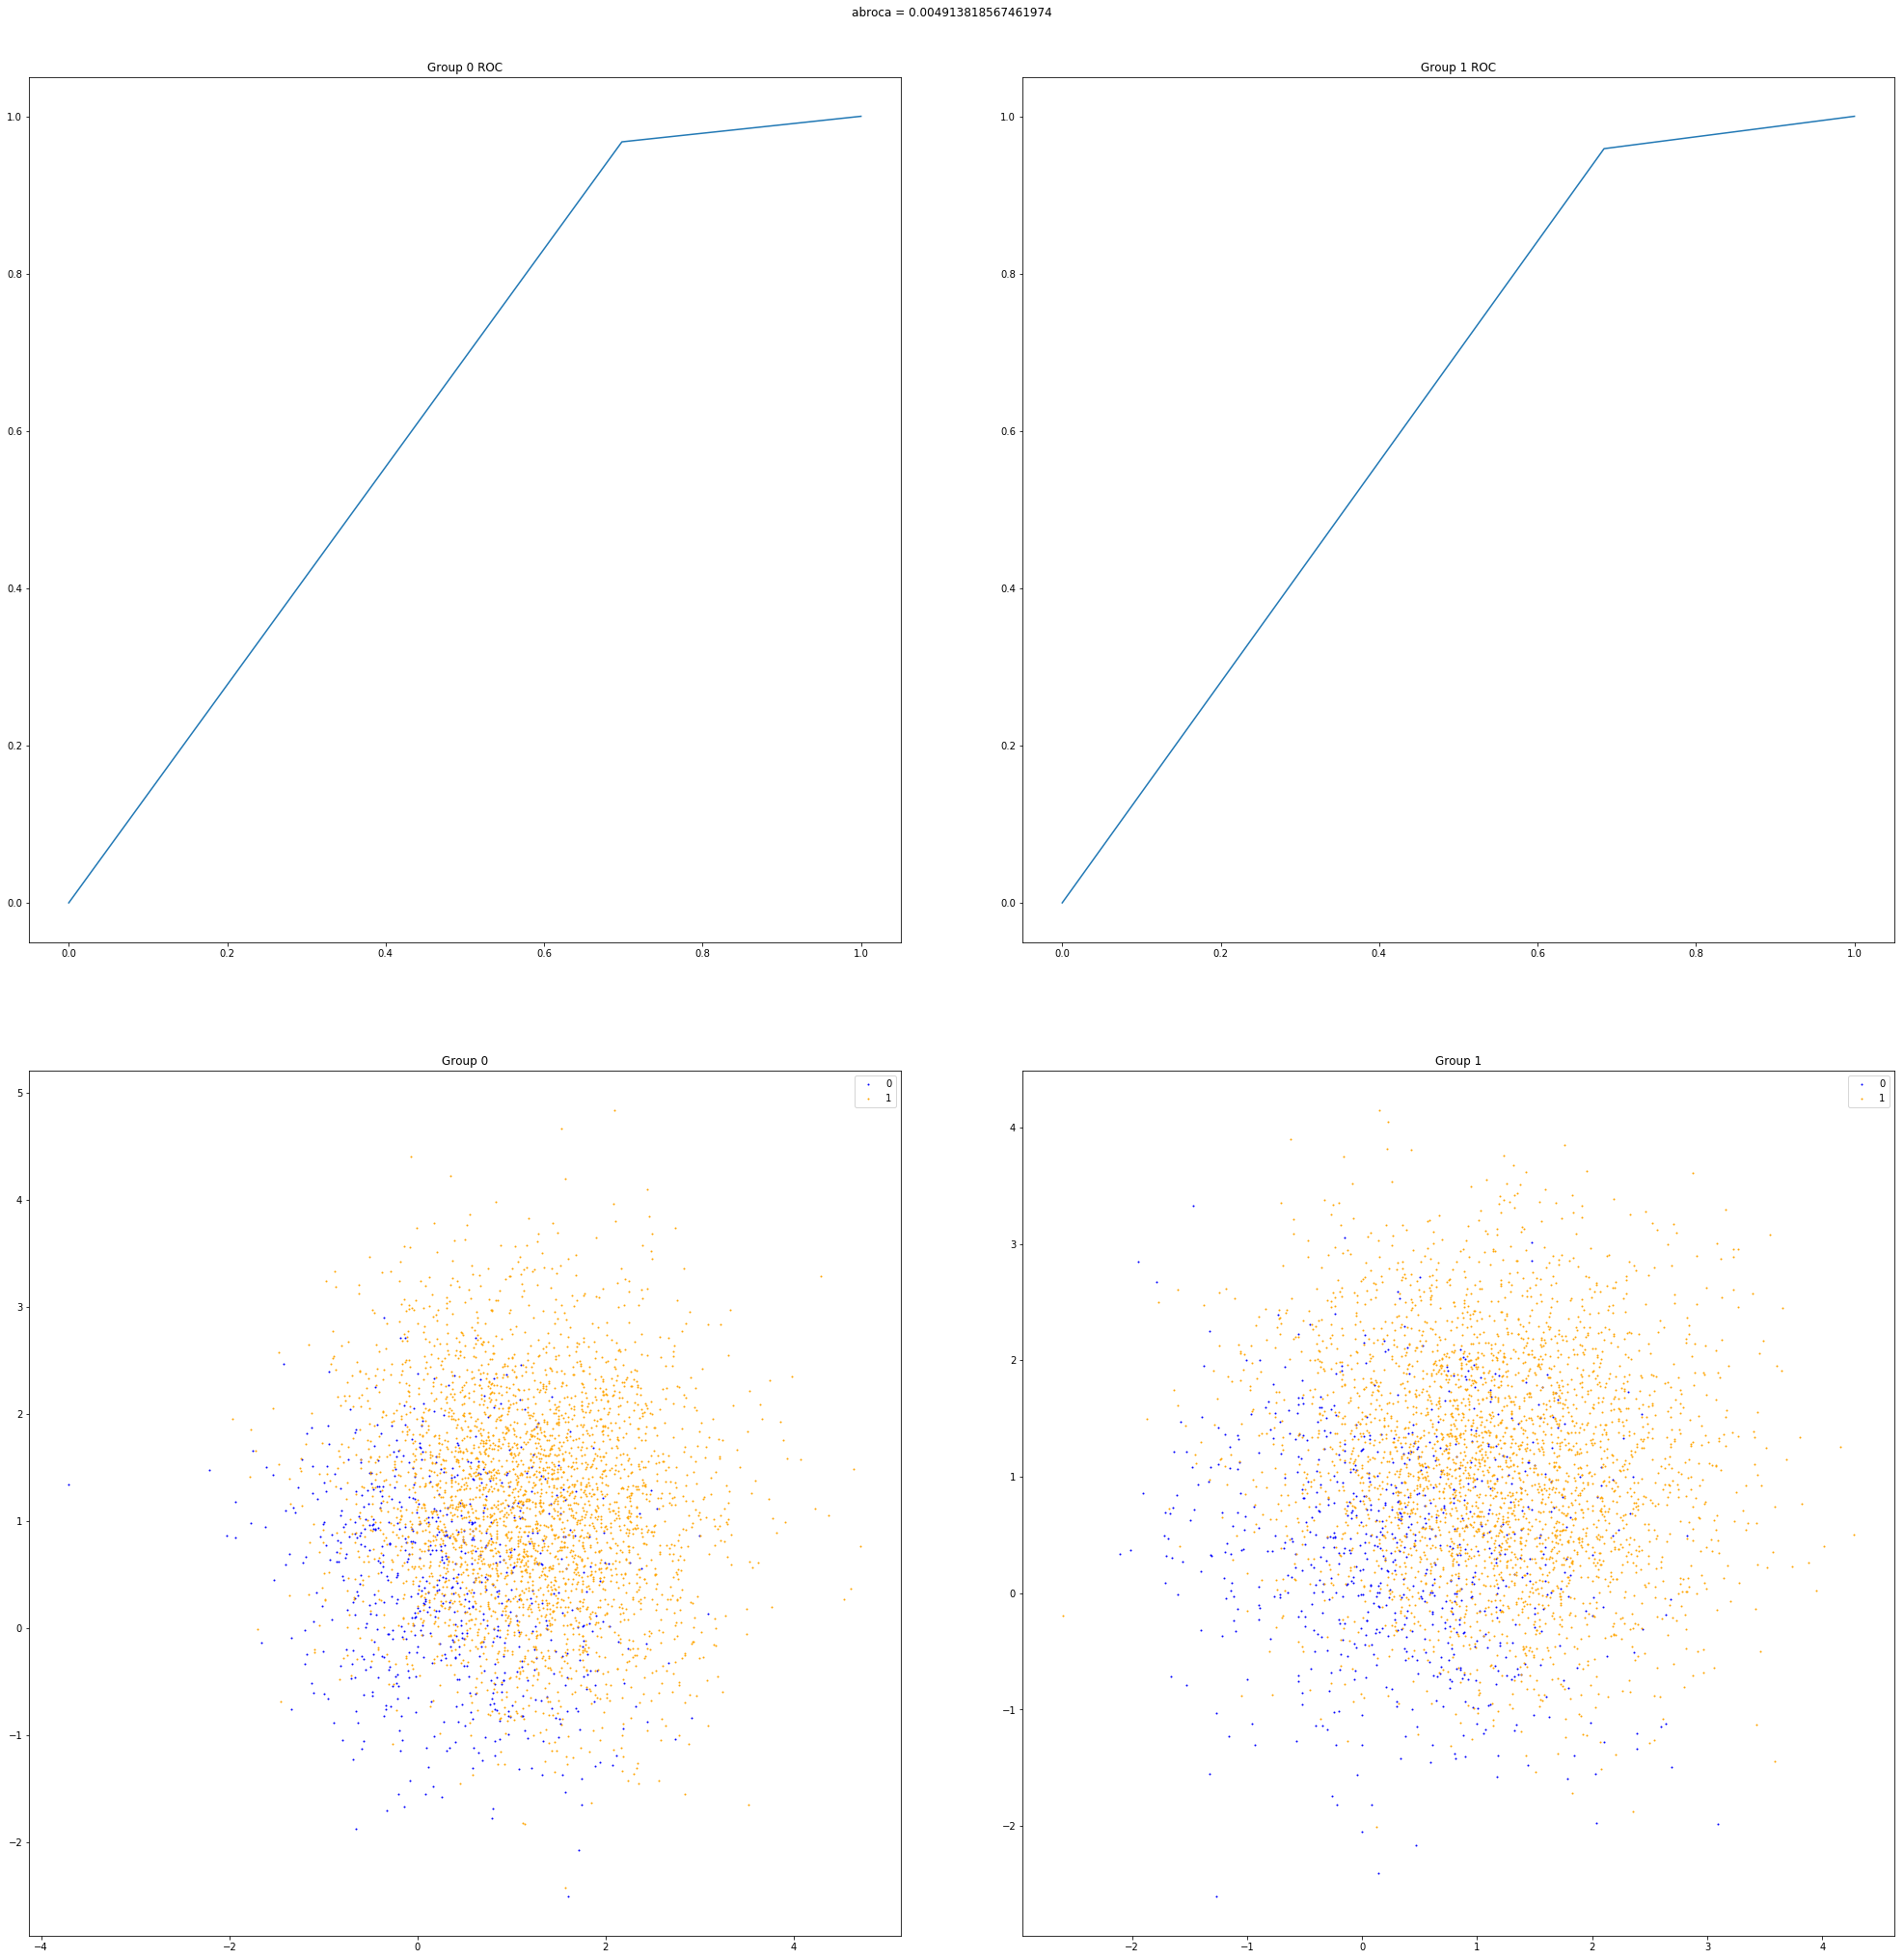

In [86]:
fig, axs = plt.subplots(2, 2, figsize=(30,30))

np.random.seed(13)
n= [5000, 5000]
X, y = simulate(subgroup_n=n, eta_sd=[.1,.1])

X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X[:n[0]], y[:n[0]], test_size=0.2, random_state=0)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X[n[0]:], y[n[0]:], test_size=0.2, random_state=0)

X_train = np.append(X_train_0, X_train_1, axis=0)
y_train = np.append(y_train_0, y_train_1, axis=0)

perm = np.random.permutation(len(y_train))

regressor = LogisticRegressionCV(cv=5, random_state=0)
regressor.fit(X_train[perm], y_train[perm])

y_pred_0 = regressor.predict(X_test_0)
y_pred_1 = regressor.predict(X_test_1)

fpr_0, tpr_0, _ = roc_curve(y_test_0, y_pred_0)
fpr_1, tpr_1, _ = roc_curve(y_test_1, y_pred_1)

abroca = compute_abroca(fpr_0,tpr_0,fpr_1,tpr_1)

axs[0,0].plot(fpr_0, tpr_0)
axs[0,0].set_title('Group 0 ROC')
axs[0,1].plot(fpr_1, tpr_1)
axs[0,1].set_title('Group 1 ROC')

plot_x0 = [a for a,b in zip(X_train_0[:,0], y_train_0) if b==0]
plot_y0 = [a for a,b in zip(X_train_0[:,1], y_train_0) if b==0]
axs[1,0].scatter(plot_x0, plot_y0, color='blue', s=1, label='0')
plot_x0 = [a for a,b in zip(X_train_0[:,0], y_train_0) if b==1]
plot_y0 = [a for a,b in zip(X_train_0[:,1], y_train_0) if b==1]
axs[1,0].scatter(plot_x0, plot_y0, color='orange', s=1, label='1')
axs[1,0].legend()
axs[1,0].set_title('Group 0')

plot_x1 = [a for a,b in zip(X_train_1[:,0], y_train_1) if b==0]
plot_y1 = [a for a,b in zip(X_train_1[:,1], y_train_1) if b==0]
axs[1,1].scatter(plot_x1, plot_y1, color='blue', s=1, label='0')
plot_x1 = [a for a,b in zip(X_train_1[:,0], y_train_1) if b==1]
plot_y1 = [a for a,b in zip(X_train_1[:,1], y_train_1) if b==1]
axs[1,1].scatter(plot_x1, plot_y1, color='orange', s=1, label='1')
axs[1,1].legend()
axs[1,1].set_title('Group 1')

fig.suptitle(f'abroca = {abroca}')
fig.tight_layout(pad=10.0)

### Regression and Main Plot

average auc score: 0.6865169205351045


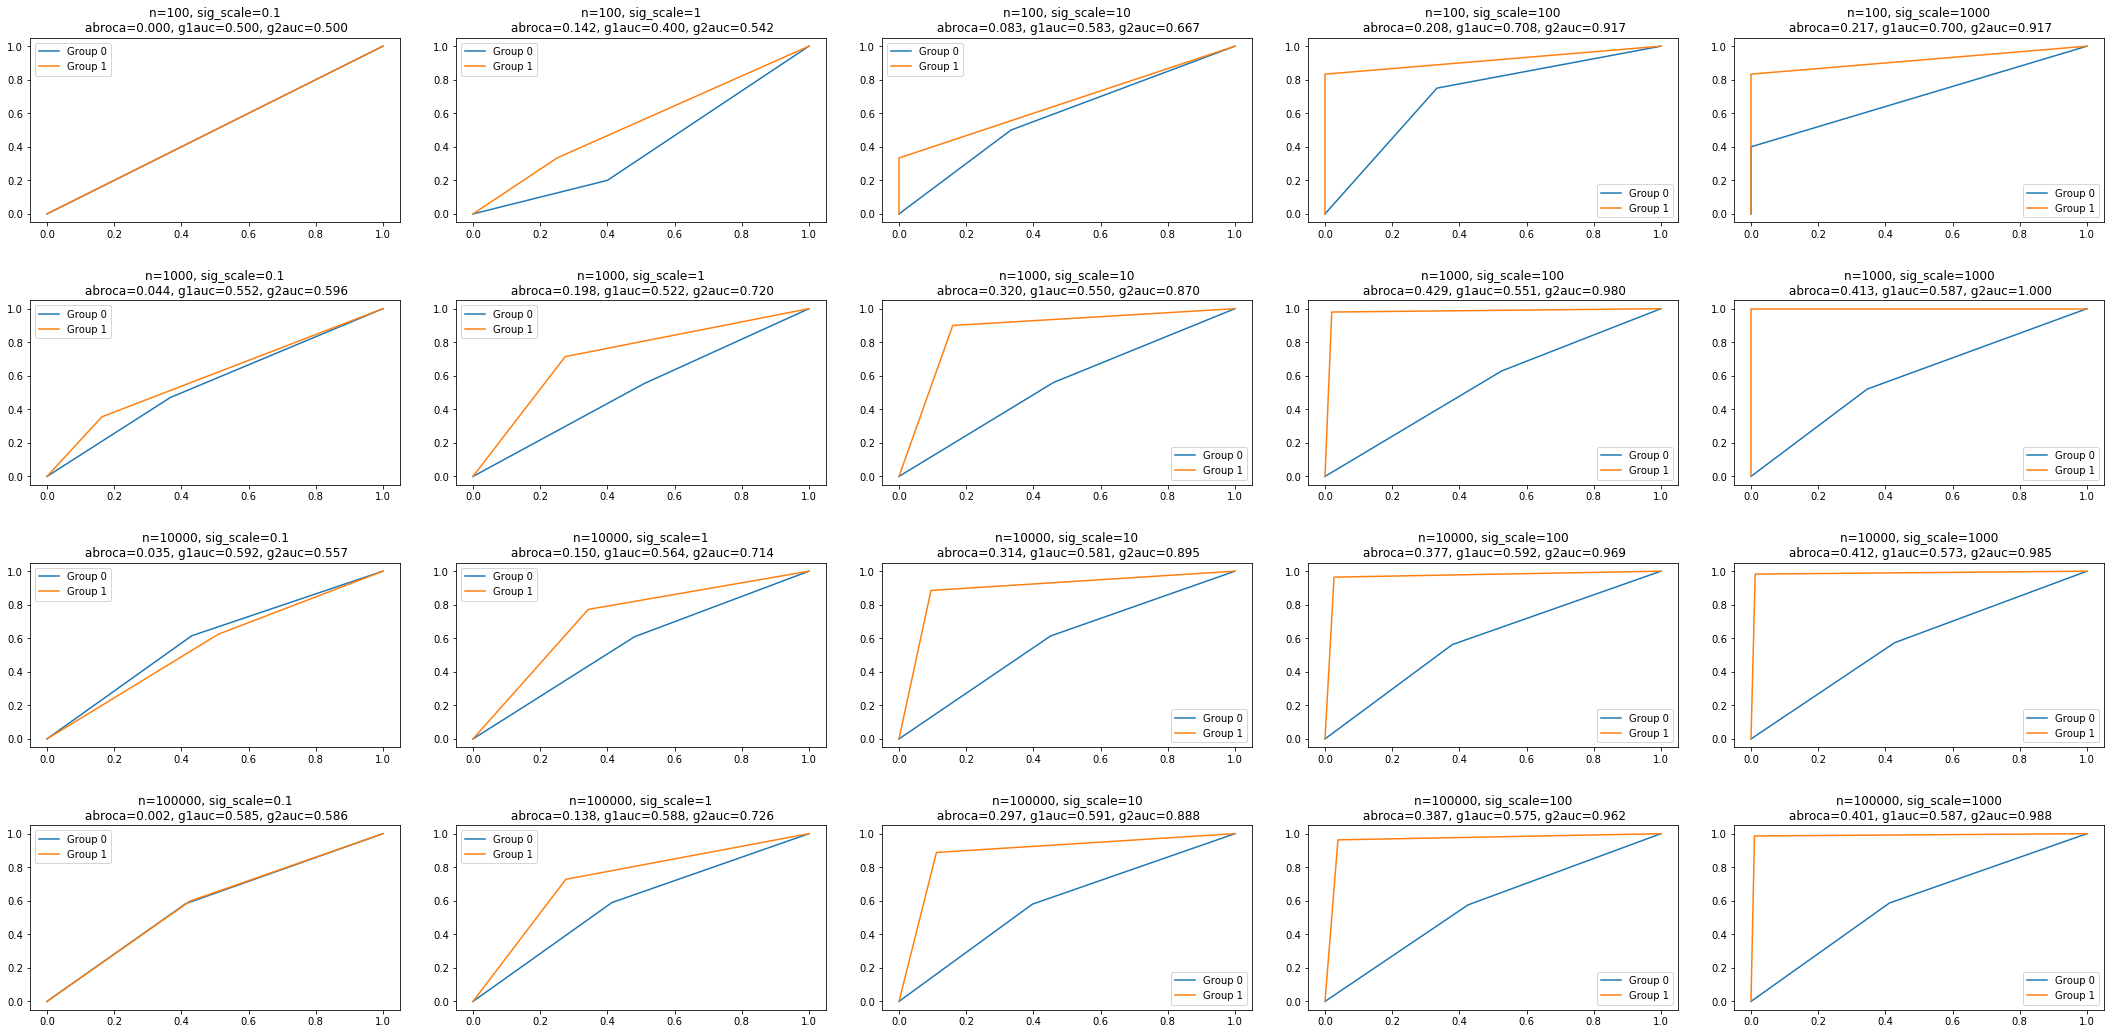

In [9]:

np.random.seed(13)
ns = [10**i for i in range(2,6)]
sig_scale_factors = [10**i for i in range(-1,4)]
fig, axs = plt.subplots(len(ns), len(sig_scale_factors), figsize=(30,15))

avg_auc = []
for row, a_n in enumerate(ns):
    for col, a_s in enumerate(sig_scale_factors):
        
        n = [a_n//2, a_n//2]
        X, y = simulate(sigma_scale_factor=a_s, subgroup_n=n, sigma_0=[1,1], sigma_1=[1,1], eta_sd=[2.5,0.05])

        X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X[:n[0]], y[:n[0]], test_size=0.2, random_state=0)
        X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X[n[0]:], y[n[0]:], test_size=0.2, random_state=0)

        X_train = np.append(X_train_0, X_train_1, axis=0)
        y_train = np.append(y_train_0, y_train_1, axis=0)

        if len(set(y_train)) == 1:
            continue
            
        #regressor = RandomForestRegressor(n_estimators = 10, random_state=0)
        #regressor = LogisticRegression() #find regularized logisticRegression - cv logistic regression
        regressor = LogisticRegressionCV(cv=5, random_state=0)
        regressor.fit(X_train, y_train)

        y_pred_0 = regressor.predict(X_test_0)
        y_pred_1 = regressor.predict(X_test_1)
        
        if len(set(y_test_0)) == 1 or len(set(y_test_1)) == 1:
            continue
        
        fpr_0, tpr_0, _ = roc_curve(y_test_0, y_pred_0)
        fpr_1, tpr_1, _ = roc_curve(y_test_1, y_pred_1)
        
        g1auc = auc(fpr_0, tpr_0)
        g2auc = auc(fpr_1, tpr_1)
        avg_auc += [g1auc, g2auc]
        abroca = compute_abroca(fpr_0,tpr_0,fpr_1,tpr_1)
        
        axs[row, col].plot(fpr_0, tpr_0, label='Group 0')
        axs[row, col].plot(fpr_1, tpr_1, label='Group 1')
        axs[row, col].legend()
        axs[row, col].set_title(f"n={sum(n)}, sig_scale={a_s}\n abroca={abroca:.3f}, g1auc={g1auc:.3f}, g2auc={g2auc:.3f}")        
fig.tight_layout(pad=3.0)
print(f"average auc score: {np.mean([_ for _ in avg_auc if not math.isnan(_)])}")

### Observation Noise VS ABROCA

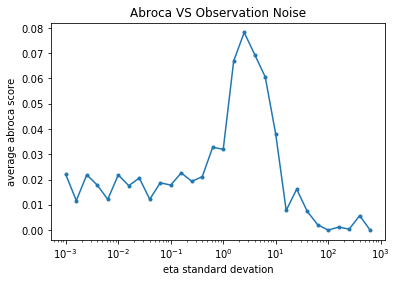

In [29]:
eta_sds = [10**i for i in np.arange(-3,3,0.2)]
np.random.seed(11)
avg_abrocas = None

for i in range(10):
    abrocas = [np.nan for _ in range(len(eta_sds))]
    for j, e in enumerate(eta_sds):
        n = [5000, 5000]
        X, y = simulate(subgroup_n=n, eta_sd=[0.1,e])

        X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X[:n[0]], y[:n[0]], test_size=0.2, random_state=0)
        X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X[n[0]:], y[n[0]:], test_size=0.2, random_state=0)

        X_train = np.append(X_train_0, X_train_1, axis=0)
        y_train = np.append(y_train_0, y_train_1, axis=0)

        if len(set(y_train)) == 1:
            continue

        #regressor = RandomForestRegressor(n_estimators = 10, random_state=0)
        #regressor = LogisticRegression()
        regressor = LogisticRegressionCV(cv=5, random_state=0)
        regressor.fit(X_train, y_train)

        y_pred_0 = regressor.predict(X_test_0)
        y_pred_1 = regressor.predict(X_test_1)

        if len(set(y_test_0)) == 1 or len(set(y_test_1)) == 1:
            continue
        
        fpr_0, tpr_0, _ = roc_curve(y_test_0, y_pred_0)
        fpr_1, tpr_1, _ = roc_curve(y_test_1, y_pred_1)

        g1auc = auc(fpr_0, tpr_0)
        g2auc = auc(fpr_1, tpr_1)
        abroca = compute_abroca(fpr_0,tpr_0,fpr_1,tpr_1)
        abrocas[j] = abroca

    if avg_abrocas is None:
        avg_abrocas = np.array(abrocas).reshape((-1,1))
    else:
        avg_abrocas = np.append(avg_abrocas, np.array(abrocas).reshape((-1,1)), axis=1)

avg_abrocas = np.nanmean(avg_abrocas, axis=1).ravel()
plt.xscale('log')
plt.yscale('linear')
plt.plot(eta_sds,avg_abrocas,marker='.')
plt.xlabel('eta standard devation')
plt.ylabel('average abroca score')
plt.title('Abroca VS Observation Noise')

if len(eta_sds) < 10:
    for i, txt in enumerate(eta_sds):
        if i == 0:
            txt = f'e={txt}'
        plt.annotate(txt, (eta_sds[i], avg_abrocas[i]))
plt.show()

### Group Imbalance VS ABROCA

[[0.17806659]
 [0.0969043 ]
 [0.14467375]
 [0.03204816]
 [0.05782038]
 [0.08384677]
 [0.24836109]
 [0.02654024]
 [0.01787257]
 [0.05825714]
 [0.12177419]
 [0.05768584]
 [0.07635943]
 [0.01623969]
 [0.13153351]]
[[0.17806659 0.04861383]
 [0.0969043  0.09471288]
 [0.14467375 0.01604278]
 [0.03204816 0.11386801]
 [0.05782038 0.12600941]
 [0.08384677 0.08417198]
 [0.24836109 0.08991259]
 [0.02654024 0.00595238]
 [0.01787257 0.04389625]
 [0.05825714 0.02631579]
 [0.12177419 0.00965701]
 [0.05768584 0.06888763]
 [0.07635943 0.03582755]
 [0.01623969 0.17581221]
 [0.13153351 0.04832075]]
[0.11334021 0.09580859 0.08035827 0.07295809 0.09191489 0.08400937
 0.16913684 0.01624631 0.03088441 0.04228646 0.0657156  0.06328674
 0.05609349 0.09602595 0.08992713]


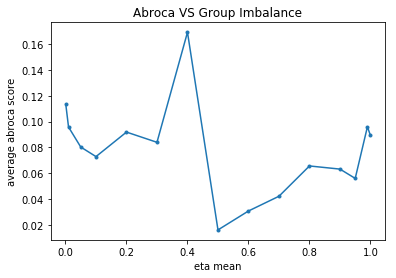

In [27]:
eta_means = [.001,.01,.05,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.99,.999]
np.random.seed(13)
avg_abrocas = None

for i in range(2):
    abrocas = [np.nan for _ in range(len(eta_means))]
    for j, e in enumerate(eta_means):
        n = [500, 500]
        X, y = simulate(subgroup_n=[int(round(sum(n)*e)), int(round(sum(n)*(1-e)))])
        X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X[:n[0]], y[:n[0]], test_size=0.2, random_state=0)
        X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X[n[0]:], y[n[0]:], test_size=0.2, random_state=0)

        X_train = np.append(X_train_0, X_train_1, axis=0)
        y_train = np.append(y_train_0, y_train_1, axis=0)

        if len(set(y_train)) == 1:
            continue

        #regressor = RandomForestRegressor(n_estimators = 10, random_state=0)
        #regressor = LogisticRegression() #find regularized logisticRegression - cv logistic regression
        regressor = LogisticRegressionCV(cv=5, random_state=0)
        regressor.fit(X_train, y_train)

        y_pred_0 = regressor.predict(X_test_0)
        y_pred_1 = regressor.predict(X_test_1)

        if len(set(y_test_0)) == 1 or len(set(y_test_1)) == 1:
            continue

        fpr_0, tpr_0, _ = roc_curve(y_test_0, y_pred_0)
        fpr_1, tpr_1, _ = roc_curve(y_test_1, y_pred_1)

        g1auc = auc(fpr_0, tpr_0)
        g2auc = auc(fpr_1, tpr_1)

        abroca = compute_abroca(fpr_0,tpr_0,fpr_1,tpr_1)
        abrocas[j] = abroca
        
    if avg_abrocas is None:
        avg_abrocas = np.array(abrocas).reshape((-1,1))
    else:
        avg_abrocas = np.append(avg_abrocas, np.array(abrocas).reshape((-1,1)), axis=1)
    print(avg_abrocas)

avg_abrocas = np.nanmean(avg_abrocas, axis=1).ravel()
print(avg_abrocas)
plt.plot(eta_means,avg_abrocas,marker='.')
plt.xlabel('eta mean')
plt.ylabel('average abroca score')
plt.title('Abroca VS Group Imbalance')

if len(eta_means) < 10:
    for i, txt in enumerate(eta_means):
        if i == 0:
            txt = f'e={txt}'
        plt.annotate(txt, (eta_means[i], avg_abrocas[i]))
plt.show()